**General Description**

This notebook provides the code for creating, training, validating, and testing a rainfall–runoff forecasting model based on an LSTM architecture. The main difference with the "LSTM_RainfallRunoof.ipynb" notebook is that the model is trained to forecast the next "n" time steps. During testing, the model outputs a forecast vector for each time step in the testing period, containing predictions for the subsequent "n" time steps.

***Authors:***
- Eduardo Acuña Espinoza (eduardo.espinoza@kit.edu)

In [1]:
# Import necessary packages
import datetime
import pickle
import random
import sys
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.append("..")
# Import classes and functions from other files
from hy2dl.datasetzoo import get_dataset
from hy2dl.evaluation.metrics import forecast_NSE, forecast_PNSE
from hy2dl.modelzoo import get_model
from hy2dl.training.loss import nse_basin_averaged
from hy2dl.utils.config import Config
from hy2dl.utils.optimizer import Optimizer
from hy2dl.utils.utils import set_random_seed, upload_to_device

# colorblind friendly palette
color_palette = {"observed": "#377eb8", "simulated": "#4daf4a"}

Part 1. Initialize information

In [5]:
# Create a dictionary where all the information will be stored
experiment_settings = {}

# Experiment name
experiment_settings["experiment_name"] = "LSTM_Forecast"

# paths to access the information
experiment_settings["path_data"] = "./data/CAMELS_US"
experiment_settings["path_entities"] = "./data/basin_id/basins_camels_us_hourly_3.txt"

# dynamic forcings and target
experiment_settings["dynamic_input"] = [
    "convective_fraction",
    "longwave_radiation",
    "potential_energy",
    "potential_evaporation",
    "pressure",
    "shortwave_radiation",
    "specific_humidity",
    "temperature",
    "total_precipitation",
    "wind_u",
    "wind_v",
]

experiment_settings["forecast_input"] = [
    "convective_fraction",
    "longwave_radiation",
    "potential_energy",
    "potential_evaporation",
    "pressure",
    "shortwave_radiation",
    "specific_humidity",
    "temperature",
    "total_precipitation",
    "wind_u",
    "wind_v",
]

experiment_settings["target"] = ["QObs(mm/h)"]
experiment_settings["forcings"] = ["nldas_hourly"]

# static attributes that will be used. If one is not using static_inputs, initialize the variable as an empty list.
experiment_settings["static_input"] = [
    "elev_mean",
    "slope_mean",
    "area_gages2",
    "frac_forest",
    "lai_max",
    "lai_diff",
    "gvf_max",
    "gvf_diff",
    "soil_depth_pelletier",
    "soil_depth_statsgo",
    "soil_porosity",
    "soil_conductivity",
    "max_water_content",
    "sand_frac",
    "silt_frac",
    "clay_frac",
    "carbonate_rocks_frac",
    "geol_permeability",
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    "high_prec_freq",
    "high_prec_dur",
    "low_prec_freq",
    "low_prec_dur",
]

# # time periods
# experiment_settings["training_period"] = ["1990-10-01 00:00:00", "2003-09-30 23:00:00"]
# experiment_settings["validation_period"] = ["2003-10-01 00:00:00", "2008-09-30 23:00:00"]
# experiment_settings["testing_period"] = ["2008-10-01 00:00:00", "2018-09-30 23:00:00"]

# time periods (short period for test)
experiment_settings["training_period"] = ["1990-10-01 00:00:00", "1992-09-30 23:00:00"]
experiment_settings["validation_period"] = ["2003-10-01 00:00:00", "2005-09-30 23:00:00"]
experiment_settings["testing_period"] = ["2008-10-01 00:00:00", "2010-09-30 23:00:00"]

# model configuration
experiment_settings["hidden_size"] = 128
experiment_settings["batch_size_training"] = 256
experiment_settings["batch_size_evaluation"] = 1024
experiment_settings["epochs"] = 3
experiment_settings["dropout_rate"] = 0.4
experiment_settings["learning_rate"] = {1: 1e-3, 5: 5e-4, 7: 1e-4}
experiment_settings["validate_every"] = 3
experiment_settings["validate_n_random_basins"] = -1

experiment_settings["seq_length_hindcast"] = 364 * 24
experiment_settings["custom_seq_processing"] = {
    "1D": {
        "n_steps": 360,
        "freq_factor": 24,
    },
    "1h": {"n_steps": 4 * 24, "freq_factor": 1},
}
experiment_settings["seq_length_forecast"] = 24
experiment_settings["predict_last_n"] = 24

experiment_settings["unique_prediction_blocks"] = False
experiment_settings["dynamic_embedding"] = {"hiddens": [10, 10, 10]}
experiment_settings["custom_seq_processing_flag"] = True

# device to train the model
# experiment_settings["device"] = "cuda:0"
experiment_settings["device"] = "cpu"

experiment_settings["num_workers"] = 4

# define random seed
experiment_settings["random_seed"] = 110

# dataset
experiment_settings["dataset"] = "hourly_camels_us"
# model
experiment_settings["model"] = "forecast_LSTM"
experiment_settings["initial_forget_bias"] = 3.0

In [6]:
# Read experiment settings
config = Config(experiment_settings)
config.init_experiment()
config.dump()

Part 2. Create datasets and dataloaders used to train/validate the model

In [7]:
# Get dataset class
Dataset = get_dataset(config)

# Dataset training
config.logger.info(f"Loading training data from {config.dataset} dataset")
total_time = time.time()

training_dataset = Dataset(cfg=config, time_period="training")

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(save_scaler=True)
training_dataset.standardize_data()

config.logger.info(f"Number of entities with valid samples: {len(training_dataset.df_ts)}")
config.logger.info(
    "Time required to process {} entities: {}".format(
        len(training_dataset.df_ts),
        datetime.timedelta(seconds=int(time.time() - total_time))
    )
)
config.logger.info(f"Number of valid training samples: {len(training_dataset)}\n")

# Dataloader training
train_loader = DataLoader(
    dataset=training_dataset,
    batch_size=config.batch_size_training,
    shuffle=True,
    drop_last=True,
    collate_fn=training_dataset.collate_fn,
    num_workers=config.num_workers,
)

# Print details of a loader´s sample to check that the format is correct
config.logger.info("Details training dataloader".center(60, "-"))
config.logger.info(f"Batch structure (number of batches: {len(train_loader)})")
config.logger.info(f"{'Key':^30}|{'Shape':^30}")
# config.logger.info("-" * 60)
# Loop through the sample dictionary and print the shape of each element
for key, value in next(iter(train_loader)).items():
    if key.startswith(("x_d", "x_conceptual")):
        config.logger.info(f"{key}")
        for i, v in value.items():
            config.logger.info(f"{i:^30}|{str(v.shape):^30}")
    else:
        config.logger.info(f"{key:<30}|{str(value.shape):^30}")

config.logger.info("")  # prints a blank line

2025-10-23 14:12:06 - Loading training data from hourly_camels_us dataset


Processing entities: 100%|##########| 3/3 [00:04<00:00,  1.41s/entity]


2025-10-23 14:12:11 - Number of entities with valid samples: 3
2025-10-23 14:12:11 - Time required to process 3 entities: 0:00:04
2025-10-23 14:12:11 - Number of valid training samples: 41747

2025-10-23 14:12:11 - ----------------Details training dataloader-----------------
2025-10-23 14:12:11 - Batch structure (number of batches: 163)
2025-10-23 14:12:11 -              Key              |            Shape             
2025-10-23 14:12:19 - x_d_1D
2025-10-23 14:12:19 -      convective_fraction      |    torch.Size([256, 360])    
2025-10-23 14:12:19 -       longwave_radiation      |    torch.Size([256, 360])    
2025-10-23 14:12:19 -        potential_energy       |    torch.Size([256, 360])    
2025-10-23 14:12:19 -     potential_evaporation     |    torch.Size([256, 360])    
2025-10-23 14:12:19 -            pressure           |    torch.Size([256, 360])    
2025-10-23 14:12:19 -      shortwave_radiation      |    torch.Size([256, 360])    
2025-10-23 14:12:19 -       specific_humidit

In [8]:
# In evaluation (validation and testing) we will create an individual dataset per basin
config.logger.info(f"Loading validation data from {config.dataset} dataset")
entities_ids = np.loadtxt(config.path_entities_validation, dtype="str").tolist()
iterator = tqdm(
    [entities_ids] if isinstance(entities_ids, str) else entities_ids,
    desc="Processing entities",
    unit="entity",
    ascii=True,
)

total_time = time.time()
validation_dataset = {}
for entity in iterator:
    dataset = Dataset(cfg=config, time_period="validation", check_NaN=False, entities_ids=entity)

    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    validation_dataset[entity] = dataset

config.logger.info(
    f"Time required to process {len(iterator)} entities: {datetime.timedelta(seconds=int(time.time() - total_time))}\n"
)

2025-10-23 14:13:35 - Loading validation data from hourly_camels_us dataset


Processing entities: 100%|##########| 3/3 [00:02<00:00,  1.17entity/s]

2025-10-23 14:13:38 - Time required to process 3 entities: 0:00:02



Part 3. Train model

In [9]:
# Initialize model
set_random_seed(cfg=config)
model = get_model(config).to(config.device)

# Initialize optimizer
optimizer = Optimizer(cfg=config, model=model)

# Training report structure
config.logger.info("Training model".center(60, "-"))
config.logger.info(f"{'':^16}|{'Trainining':^21}|{'Validation':^21}|")
config.logger.info(f"{'Epoch':^5}|{'LR':^10}|{'Loss':^10}|{'Time':^10}|{'Metric':^10}|{'Time':^10}|")

total_time = time.time()
# Loop through epochs
for epoch in range(1, config.epochs + 1):
    train_time = time.time()
    loss_evol = []
    # Training -------------------------------------------------------------------------------------------------------
    model.train()
    # Loop through the different batches in the training dataset
    iterator = tqdm(
        train_loader,
        desc=f"Epoch {epoch}/{config.epochs}. Training",
        unit="batches",
        ascii=True,
        leave=False,
    )

    for idx, sample in enumerate(iterator):
        # reach maximum iterations per epoch
        if config.max_updates_per_epoch is not None and idx >= config.max_updates_per_epoch:
            break

        sample = upload_to_device(sample, config.device)  # upload tensors to device
        optimizer.optimizer.zero_grad()  # sets gradients to zero

        # Forward pass of the model
        pred = model(sample)
        # Calcuate loss
        loss = nse_basin_averaged(y_sim=pred["y_hat"], y_obs=sample["y_obs"], per_basin_target_std=sample["std_basin"])

        # Backpropagation (calculate gradients)
        loss.backward()

        # Update model parameters (e.g, weights and biases)
        optimizer.clip_grad_and_step(epoch, idx)

        # Keep track of the loss per batch
        loss_evol.append(loss.item())
        iterator.set_postfix({"average loss": f"{np.mean(loss_evol):.3f}"})

        # remove elements from cuda to free memory
        del sample, pred
        torch.cuda.empty_cache()

    # training report
    lr = optimizer.optimizer.param_groups[0]["lr"]
    mean_loss = np.mean(loss_evol)
    train_duration = str(datetime.timedelta(seconds=int(time.time() - train_time)))
    report = f"{epoch:^5}|{lr:^10.5f}|{mean_loss:^10.3f}|{train_duration:^10}|"

    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % config.validate_every == 0:
        val_time = time.time()
        model.eval()
        validation_results = {}
        with torch.no_grad():
            # If we define validate_n_random_basins as 0 or negative, we take all the basins. Otherwise, we randomly 
            # select the number of basins defined in validate_n_random_basins
            if config.validate_n_random_basins <= 0:
                validation_basin_ids = validation_dataset.keys()
            else:
                validation_basin_ids = random.sample(list(validation_dataset.keys()), config.validate_n_random_basins)

            # Go through each basin
            iterator = tqdm(
                validation_basin_ids,
                desc=f"Epoch {epoch}/{config.epochs}. Validation",
                unit="basins",
                ascii=True,
                leave=False,
            )

            for basin in iterator:
                loader = DataLoader(
                    dataset=validation_dataset[basin],
                    batch_size=config.batch_size_evaluation,
                    shuffle=False,
                    drop_last=False,
                    collate_fn=validation_dataset[basin].collate_fn,
                    num_workers=config.num_workers,
                )

                dates, observed_values, simulated_values = [], [], []
                for i, sample in enumerate(loader):
                    sample = upload_to_device(sample, config.device)  # upload tensors to device
                    pred = model(sample)
                    # backtransformed information
                    y_sim = (
                        pred["y_hat"] * validation_dataset[basin].scaler["y_std"].to(config.device)
                    )
                    y_mean = validation_dataset[basin].scaler["y_mean"].to(config.device)
                    y_sim = y_sim + y_mean

                    # Join the results from the different batches
                    dates.extend(sample["date_issue_fc"])
                    observed_values.extend(sample["persistent_q"].cpu().detach().numpy())
                    simulated_values.append(y_sim.cpu().detach().numpy())
                    if i == len(loader) - 1:
                        dates.extend(sample["date"][-1, :])
                        observed_values.extend(sample["y_obs"][-1, :].cpu().detach().numpy())

                    # remove from cuda
                    del sample, pred, y_sim
                    torch.cuda.empty_cache()

                # Construct dataframe with observed and simulated values
                df = pd.DataFrame(index=dates)
                df["Observed"] = np.concatenate(observed_values, axis=0)
                y_sim = np.squeeze(np.concatenate(simulated_values, axis=0), -1)
                y_sim = np.concatenate((y_sim, np.full([y_sim.shape[1], y_sim.shape[1]], np.nan)), axis=0)
                df[[f"lead_time_{i + 1}" for i in range(y_sim.shape[1])]] = y_sim

                validation_results[basin] = df

            # average loss validation
            loss_validation = forecast_NSE(results=validation_results).median().mean()
            report += f"{loss_validation:^10.3f}|{str(datetime.timedelta(seconds=int(time.time() - val_time))):^10}|"

    # No validation
    else:
        report += f"{'':^10}|{'':^10}|"

    # Print report and save model
    config.logger.info(report)
    torch.save(model.state_dict(), config.path_save_folder / "model" / f"model_epoch_{epoch}")
    # modify learning rate
    optimizer.update_optimizer_lr(epoch=epoch)

# print total training time
config.logger.info(f"Total training time: {datetime.timedelta(seconds=int(time.time() - total_time))}\n")

2025-10-23 14:13:50 - -----------------------Training model-----------------------
2025-10-23 14:13:50 -                 |     Trainining      |     Validation      |
2025-10-23 14:13:50 - Epoch|    LR    |   Loss   |   Time   |  Metric  |   Time   |


2025-10-23 14:15:14 -   1  | 0.00100  |  6.580   | 0:01:24  |          |          |


2025-10-23 14:16:43 -   2  | 0.00100  |  4.112   | 0:01:28  |          |          |


2025-10-23 14:19:10 -   3  | 0.00100  |  2.426   | 0:01:26  |  0.491   | 0:01:01  |
2025-10-23 14:19:10 - Total training time: 0:05:20



Part 4. Test model

In [ ]:
# In case I already trained an LSTM I can re-construct the model. I just need to define the epoch for which I want to
# re-construct the model
# model = get_model(config).to(config.device)
# model.load_state_dict(torch.load(config.path_save_folder / "model" / "model_epoch_20", map_location=config.device))

In [10]:
# Read previously generated scaler
with open(config.path_save_folder / "scaler.pickle", "rb") as file:
    scaler = pickle.load(file)

In [11]:
# In evaluation (validation and testing) we will create an individual dataset per basin
config.logger.info(f"Loading testing data from {config.dataset} dataset")

entities_ids = np.loadtxt(config.path_entities_testing, dtype="str").tolist()
iterator = tqdm(
    [entities_ids] if isinstance(entities_ids, str) else entities_ids,
    desc="Processing entities",
    unit="entity",
    ascii=True,
)

total_time = time.time()
testing_dataset = {}
for entity in iterator:
    dataset = Dataset(cfg=config, time_period="testing", check_NaN=False, entities_ids=entity)

    dataset.scaler = scaler
    dataset.standardize_data(standardize_output=False)
    testing_dataset[entity] = dataset

config.logger.info(
    f"Time required to process {len(iterator)} entities: {datetime.timedelta(seconds=int(time.time() - total_time))}\n"
)

2025-10-23 14:21:39 - Loading testing data from hourly_camels_us dataset


Processing entities: 100%|##########| 3/3 [00:02<00:00,  1.17entity/s]

2025-10-23 14:21:42 - Time required to process 3 entities: 0:00:02



In [12]:
config.logger.info("Testing model".center(60, "-"))
total_time = time.time()

model.eval()
test_results = {}
with torch.no_grad():
    # Go through each basin
    iterator = tqdm(testing_dataset, desc="Testing", unit="basins", ascii=True)
    for basin in iterator:
        loader = DataLoader(
            dataset=testing_dataset[basin],
            batch_size=config.batch_size_evaluation,
            shuffle=False,
            drop_last=False,
            collate_fn=testing_dataset[basin].collate_fn,
            num_workers=config.num_workers,
        )

        dates, simulated_values, observed_values = [], [], []
        for i, sample in enumerate(loader):
            sample = upload_to_device(sample, config.device)  # upload tensors to device
            pred = model(sample)
            # backtransformed information
            y_sim = pred["y_hat"] * testing_dataset[basin].scaler["y_std"].to(config.device) + testing_dataset[
                basin
            ].scaler["y_mean"].to(config.device)

            # Join the results from the different batches
            dates.extend(sample["date_issue_fc"])
            observed_values.extend(sample["persistent_q"].cpu().detach().numpy())
            simulated_values.append(y_sim.cpu().detach().numpy())
            if i == len(loader) - 1:
                dates.extend(sample["date"][-1, :])
                observed_values.extend(sample["y_obs"][-1, :].cpu().detach().numpy())

            # remove from cuda
            del sample, pred, y_sim
            torch.cuda.empty_cache()

        # Construct dataframe with observed and simulated values
        df = pd.DataFrame(index=dates)
        df["Observed"] = np.concatenate(observed_values, axis=0)
        y_sim = np.squeeze(np.concatenate(simulated_values, axis=0), -1)
        y_sim = np.concatenate((y_sim, np.full([y_sim.shape[1], y_sim.shape[1]], np.nan)), axis=0)
        df[[f"lead_time_{i + 1}" for i in range(y_sim.shape[1])]] = y_sim

        # Save the dataframe in a basin-indexed dictionary
        test_results[basin] = df

# Save results as a pickle file
with open(config.path_save_folder / "test_results.pickle", "wb") as f:
    pickle.dump(test_results, f)

config.logger.info(f"Total testing time: {datetime.timedelta(seconds=int(time.time() - total_time))}")

2025-10-23 14:23:25 - -----------------------Testing model------------------------


Testing: 100%|##########| 3/3 [00:44<00:00, 14.83s/basins]

2025-10-23 14:24:09 - Total testing time: 0:00:44


Part 5. Initial analysis

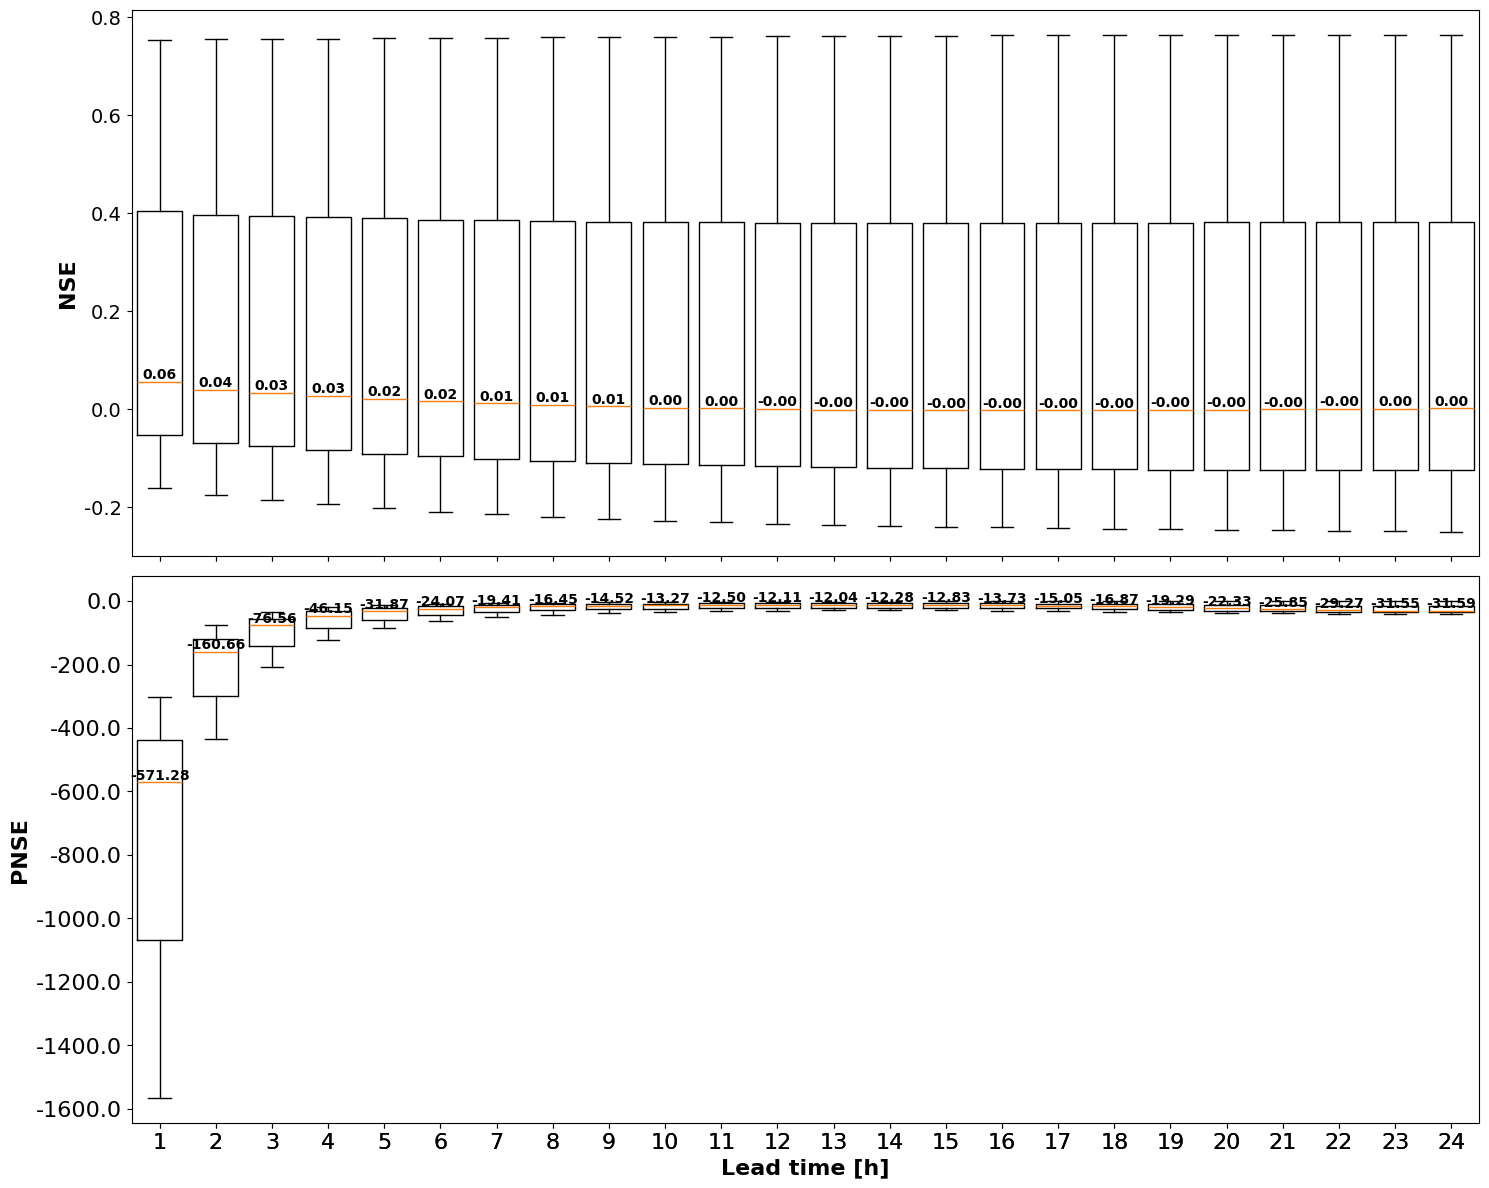

In [13]:
df_NSE = forecast_NSE(results=test_results)
df_PNSE = forecast_PNSE(results=test_results)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12), sharex=True)  # Share x-axis

# First subplot: NSE
axes[0].boxplot(
    df_NSE.dropna().values,
    widths=0.8,
    positions=np.arange(len(df_NSE.columns)) + 1,
    showfliers=False,
)

medians = df_NSE.median(axis=0).values
for i, median in enumerate(medians):
    axes[0].text(
        i + 1,
        median,
        f"{median:.2f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontsize=10,
        fontweight="bold",
        color="black",
    )

axes[0].set_ylabel("NSE", fontsize=16, fontweight="bold")
axes[0].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
axes[0].tick_params(axis="both", labelsize=14)

# Second subplot: Boxplot
axes[1].boxplot(
    df_PNSE.dropna().values,
    widths=0.8,
    positions=np.arange(len(df_PNSE.columns)) + 1,
    showfliers=False,
)

# Add median values as text
medians = df_PNSE.median(axis=0).values
for i, median in enumerate(medians):
    axes[1].text(
        i + 1,
        median,
        f"{median:.2f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontsize=10,
        fontweight="bold",
        color="black",
    )

axes[1].set_xlabel("Lead time [h]", fontsize=16, fontweight="bold")
axes[1].set_ylabel("PNSE", fontsize=16, fontweight="bold")
axes[1].tick_params(axis="both", labelsize=16)
axes[1].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))

# Adjust layout
plt.tight_layout()
plt.show()

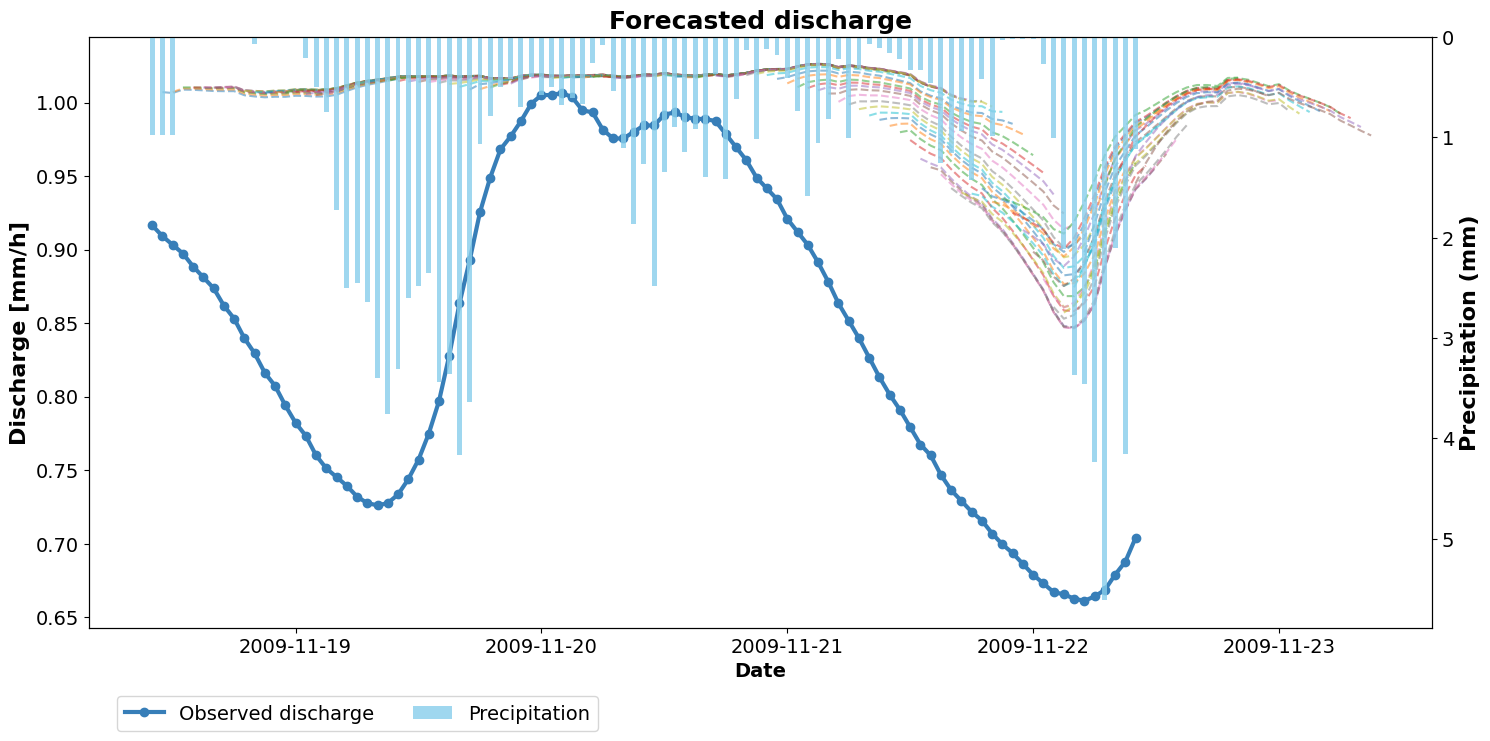

In [18]:
# Plot random basin and date
basin_to_analyze = random.sample(list(test_results.keys()), 1)[0]

# Establish period of interest as 48 hours before and after a random peak
date = random.sample(list(test_results[basin_to_analyze].Observed.nlargest(200).index), 1)[0]
window_size = 48
start_date = date - pd.Timedelta(hours=window_size)
end_date = date + pd.Timedelta(hours=window_size)
period_of_interest = [start_date, end_date]

# Filter the results
df_period_of_interest = test_results[basin_to_analyze].loc[period_of_interest[0] : period_of_interest[1], :]

# Precipitation
df_prec = (
    testing_dataset[basin_to_analyze]
    .df_ts[basin_to_analyze]
    .loc[period_of_interest[0] : period_of_interest[1], ["total_precipitation"]]
)

# Create figure
fig, ax1 = plt.subplots(figsize=(15, 7.5))

# Observe series
ax1.plot(
    df_period_of_interest["Observed"],
    label="Observed discharge",
    color=color_palette["observed"],
    linewidth=3,
    marker="o",
)

# Simulated forecasted series
for i in range(df_period_of_interest.shape[0] - 1):
    time_slide = pd.date_range(
        start=df_period_of_interest.index[i + 1], periods=df_period_of_interest.shape[1] - 1, freq="h"
    )

    forecast = df_period_of_interest.iloc[i, 1:].values
    ax1.plot(time_slide, forecast, alpha=0.5, linestyle="--")

# Precipitation
ax2 = ax1.twinx()
ax2.bar(df_prec.index, df_prec.squeeze().values, color="skyblue", width=0.02, label="Precipitation", alpha=0.8)

# Format plot
ax1.set_xlabel("Date", fontsize=14, fontweight="bold")
ax1.tick_params(axis="x", labelsize=14)
ax1.set_ylabel("Discharge [mm/h]", fontsize=16, fontweight="bold")
ax1.tick_params(axis="y", labelsize=14)
ax1.set_title("Forecasted discharge", fontsize=18, fontweight="bold")

ax2.set_ylabel("Precipitation (mm)", fontsize=16, fontweight="bold")
ax2.tick_params(axis="both", which="major", labelsize=14)
ax2.invert_yaxis()

# Create legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper center", bbox_to_anchor=(0.2, -0.1), ncol=5, fontsize=14)

plt.tight_layout()
plt.show()